## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 4.0MB/s ta 0:00:011
Requirement not upgraded as not directly required: urllib3<1.23.0,>=1.15 in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (1.22)
Requirement not upgraded as not directly required: six>=1.10 in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (1.11.0)
Requirement not upgraded as not directly required: certifi in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (2018.10.15)
Requirement not upgraded as not directly required: python-dateutil in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (2.7.3)
Requirement not upgraded as not directly required: requests in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (2.18.4)
Requirement not upgraded as not directly required: tqdm in /home/ubuntu/anaconda3/lib/python3.6/site-packages (from kaggle) (4.28.1)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/ubuntu/ana

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [22]:
!find . -name *.json -print

./kaggle.json


In [23]:
! mkdir -p ~/.kaggle/
! mv ./kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [28]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/planet')

In [25]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99%|███████████████████████████████████████▌| 593M/600M [00:08<00:00, 89.4MB/s]
100%|████████████████████████████████████████| 600M/600M [00:08<00:00, 71.3MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 8.73MB/s]


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [26]:
! conda install -y -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3

  added / updated specs: 
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         565 KB  haasad

The following NEW packages will be INSTALLED:

    eidl7zip: 1.0.0-1 haasad


eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [27]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [29]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [30]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [31]:
np.random.seed(42)
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
       .random_split_by_pct(0.2))

In [32]:
data = (src.datasets()
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

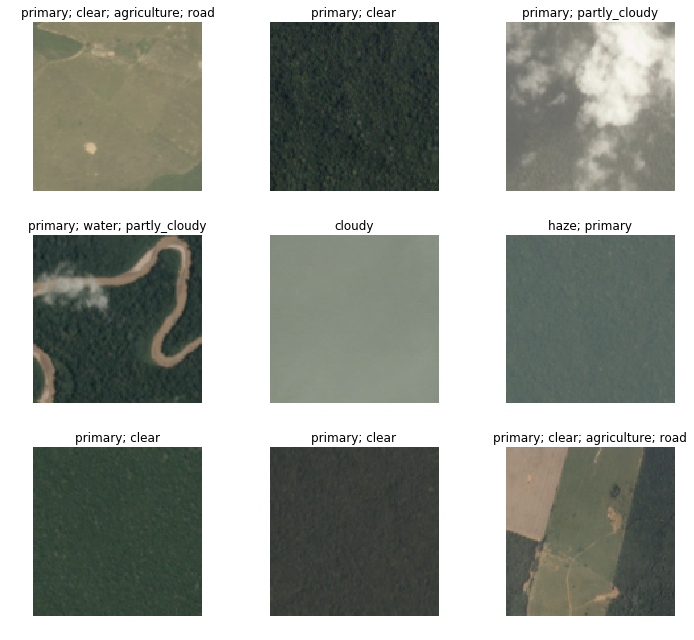

In [33]:
data.show_batch(rows=3, figsize=(10,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [34]:
arch = models.resnet50

In [35]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 37463660.66it/s]


We use the LR Finder to pick a good learning rate.

In [36]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


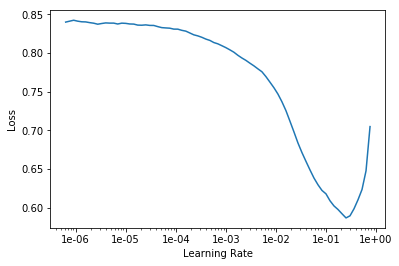

In [37]:
learn.recorder.plot()

Then we can fit the head of our network.

In [38]:
lr = 0.01

In [39]:
learn.fit_one_cycle(5, slice(lr))

Total time: 16:41
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.116041    0.104819    0.946699         0.907884  (03:22)
2      0.111401    0.096602    0.952345         0.915252  (03:19)
3      0.101077    0.090585    0.952055         0.921402  (03:19)
4      0.093508    0.086527    0.956793         0.926343  (03:19)
5      0.087525    0.084600    0.957897         0.927040  (03:19)



In [40]:
learn.save('plant-stage-1-rn50')

In [44]:
#!find . -name *.pth -print

!find . -name plant-stage-1-rn50* -print

...And fine-tune the whole model:

In [45]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


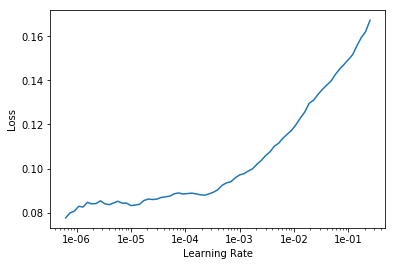

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 21:58
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096264    0.089471    0.956095         0.922179  (04:22)
2      0.094562    0.088242    0.956560         0.925594  (04:24)
3      0.091095    0.085646    0.956945         0.926960  (04:24)
4      0.083560    0.083520    0.958442         0.928591  (04:23)
5      0.080698    0.082402    0.959140         0.929526  (04:23)



In [48]:
learn.save('plant-stage-2-rn50')

In [49]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [50]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


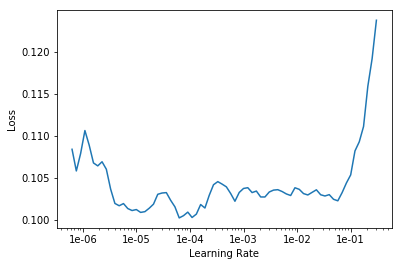

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [51]:
lr=1e-2/2

In [52]:
learn.fit_one_cycle(5, slice(lr))

Total time: 56:04
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.087272    0.085713    0.955826         0.923667  (11:25)
2      0.088790    0.087628    0.956931         0.919352  (11:09)
3      0.085970    0.082418    0.959735         0.929252  (11:10)
4      0.083377    0.081050    0.959118         0.930969  (11:08)
5      0.079672    0.080408    0.960193         0.931159  (11:10)



In [53]:
learn.save('stage-1-256-rn50')

In [54]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083591    0.082895    0.968310         0.928210  (03:41)
2      0.088286    0.083184    0.967424         0.928812  (03:40)
3      0.083495    0.083084    0.967998         0.929224  (03:40)
4      0.080143    0.081338    0.968564         0.931363  (03:40)
5      0.074927    0.080691    0.968819         0.931414  (03:41)



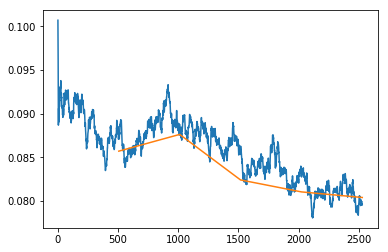

In [55]:
learn.recorder.plot_losses()

In [56]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))